In [273]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import linregress
from sklearn.metrics import r2_score

*Data Import*

In [303]:
df = pd.read_csv('/content/rp.csv')

*Data Cleaning*

In [304]:
df['COMPANY_MENTION'].fillna(0, inplace = True)
df['COMPANY_MENTION'] = df['COMPANY_MENTION'].replace('[]',0)
df.loc[df['COMPANY_MENTION'] != 0, 'COMPANY_MENTION'] = 1
df['PROFILE_MENTION'].fillna(0, inplace = True)
df.loc[df['PROFILE_MENTION'] != 0, 'PROFILE_MENTION'] = 1
df['POLL_ID'].fillna(0, inplace = True)
df.loc[df['POLL_ID'] != 0, 'POLL_ID'] = 1
df['PUBLISHED_DATE'] = pd.to_datetime(df['PUBLISHED_DATE'], utc = True)
df['DATE_EXTRACT'] = pd.to_datetime(df['DATE_EXTRACT'], utc = True)
df['AGE_IN_DAYS'] = (df['DATE_EXTRACT'] - df['PUBLISHED_DATE']).dt.days
df['POLL_ID'] = df['POLL_ID'].astype(int)
df = df[['TEXT','CHARACTER_COUNT','TAGS','TAGS_COUNT','EMOJIS_COUNT','LINKS_COUNT','PROFILE_MENTION','COMPANY_MENTION','CONTENT','POLL_ID','COMMENTS','LIKES','AGE_IN_DAYS']]
df['ENGAGEMENT'] = df['LIKES']+(df['COMMENTS']*5)

<ipython-input-304-49b3c81223d6>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ENGAGEMENT'] = df['LIKES']+(df['COMMENTS']*5)


Initial Model

In [277]:
pm = pd.get_dummies(df['PROFILE_MENTION'], prefix='PROFILEMENTION', drop_first=True)
cm = pd.get_dummies(df['COMPANY_MENTION'], prefix='COMPANYMENTION', drop_first=True)
poll = pd.get_dummies(df['POLL_ID'], prefix='POLL', drop_first=True)
con = pd.get_dummies(df['CONTENT'], prefix='CONTENT', drop_first=True)
X = pd.concat([pm,cm,poll,con,df['CHARACTER_COUNT'],df['AGE_IN_DAYS'], df['LINKS_COUNT'],df['EMOJIS_COUNT'],df['TAGS_COUNT']], axis = 1)
Y = df['ENGAGEMENT']

In [279]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42, shuffle=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Create a LinearRegression object
lr_model = LinearRegression()
# Fit the model on the training data
lr_model.fit(X_scaled, Y_train)
Y_pred = lr_model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

In [280]:
slope, intercept, r_value, p_value, std_err = linregress(Y_test, Y_pred)
r_squared = r_value ** 2
r_squared

0.08059184456002483

In [281]:
rmse

3527.303281157933

*Extra Preprocessing*

In [ ]:
conditions = [(df['EMOJIS_COUNT'] == 0),(df['EMOJIS_COUNT'] > 0)]
categories = [False,True]
df['EMOJIS_USED'] = pd.DataFrame(np.select(conditions, categories))

In [283]:
conditions = [(df['TAGS_COUNT'] == 0),(df['TAGS_COUNT'] < 6),(df['TAGS_COUNT'] >= 6)]
categories = ['0','1-5','6 and more']
df['TAGS_USED'] = pd.DataFrame(np.select(conditions, categories))

<ipython-input-283-946af81a2d48>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TAGS_USED'] = pd.DataFrame(np.select(conditions, categories))


*Second Model*

In [284]:
pm = pd.get_dummies(df['PROFILE_MENTION'], prefix='PROFILEMENTION', drop_first=True)
cm = pd.get_dummies(df['COMPANY_MENTION'], prefix='COMPANYMENTION', drop_first=True)
poll = pd.get_dummies(df['POLL_ID'], prefix='POLL', drop_first=True)
con = pd.get_dummies(df['CONTENT'], prefix='CONTENT', drop_first=True)
lin =  pd.get_dummies(df['LINKS_COUNT'], prefix='LINKS', drop_first=True)
tag =  pd.get_dummies(df['TAGS_USED'], prefix='TAGS', drop_first=True)
emo =  pd.get_dummies(df['EMOJIS_USED'], prefix='EMOJIS', drop_first=True)
X = pd.concat([pm,cm,poll,con,lin,tag,emo,df['CHARACTER_COUNT'],df['AGE_IN_DAYS']], axis = 1)

In [285]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42, shuffle=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Create a LinearRegression object
lr_model = LinearRegression()
# Fit the model on the training data
lr_model.fit(X_scaled, Y_train)
Y_pred = lr_model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

In [286]:
slope, intercept, r_value, p_value, std_err = linregress(Y_test, Y_pred)
r_squared = r_value ** 2
r_squared

0.09293875232129989

In [287]:
rmse

3634.0893231108107

*Third Model*

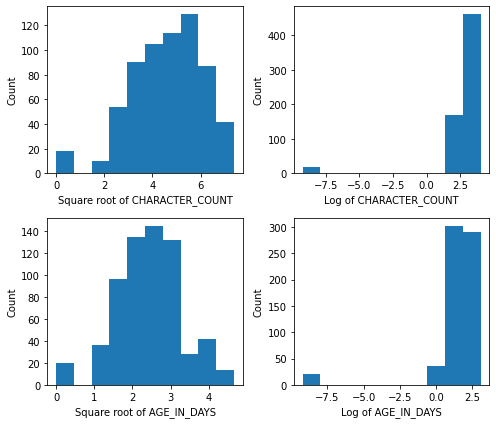

In [327]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, 2, figsize=(7,6))  # Increase figure size to 8x8 inches
ax[0, 0].hist(np.sqrt(X['CHARACTER_COUNT']))
ax[0, 0].set_xlabel('Square root of CHARACTER_COUNT')
ax[0, 0].set_ylabel('Count')
ax[0, 1].hist(np.log(X['CHARACTER_COUNT']+0.0001))
ax[0, 1].set_xlabel('Log of CHARACTER_COUNT')
ax[0, 1].set_ylabel('Count')
ax[1, 0].hist(np.sqrt(X['AGE_IN_DAYS']))
ax[1, 0].set_xlabel('Square root of AGE_IN_DAYS')
ax[1, 0].set_ylabel('Count')
ax[1, 1].hist(np.log(X['AGE_IN_DAYS']+0.0001))
ax[1, 1].set_xlabel('Log of AGE_IN_DAYS')
ax[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()



In [290]:
X['CHARACTER_COUNT'] = np.sqrt(X['CHARACTER_COUNT'])
X['AGE_IN_DAYS'] = np.sqrt(X['AGE_IN_DAYS'])
Y = df['ENGAGEMENT']

In [291]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42, shuffle=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Create a LinearRegression object
lr_model = LinearRegression()
# Fit the model on the training data
lr_model.fit(X_scaled, Y_train)
Y_pred = lr_model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

In [292]:
slope, intercept, r_value, p_value, std_err = linregress(Y_test, Y_pred)
r_squared = r_value ** 2
r_squared

0.09594784987751237

In [293]:
rmse

3543.2457294511487

*Fourth Model*

Text(0, 0.5, 'Count')

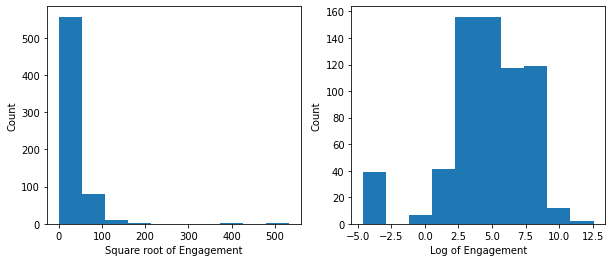

In [338]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))  # Increase figure size to 8x8 inches
ax[0].hist(np.sqrt(Y))
ax[0].set_xlabel('Square root of Engagement')
ax[0].set_ylabel('Count')
ax[1].hist(np.log(Y+0.01))
ax[1].set_xlabel('Log of Engagement')
ax[1].set_ylabel('Count')

In [294]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42, shuffle=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Create a LinearRegression object
lr_model = LinearRegression()
# Fit the model on the training data
lr_model.fit(X_scaled, np.log(Y_train + 0.01))
Y_pred = np.exp(lr_model.predict(X_test_scaled))-0.01
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

In [295]:
slope, intercept, r_value, p_value, std_err = linregress(Y_test, Y_pred)
r_squared = r_value ** 2
r_squared

0.2048926044148476

In [296]:
rmse

1713.04705388622

In [ ]:
coefficients = lr_model.coef_
intercept = lr_model.intercept_

In [313]:
X.drop(columns = 'ENGAGEMENT').columns

Index(['PROFILEMENTION_1', 'COMPANYMENTION_1', 'POLL_1', 'CONTENT_Document',
       'CONTENT_Image', 'CONTENT_Poll', 'CONTENT_Text',
       'CONTENT_Video (external)', 'CONTENT_Video (native)', 'LINKS_1',
       'LINKS_2', 'TAGS_1-5', 'TAGS_6 and more', 'EMOJIS_1', 'CHARACTER_COUNT',
       'AGE_IN_DAYS'],
      dtype='object')

In [310]:
coefficients

array([ 3.30271762e-01, -3.52527927e-01,  3.78103653e+13, -2.80962113e-01,
        4.50109556e-01, -3.78103653e+13, -2.39827844e-02,  4.91149952e-02,
       -4.10661389e-02,  3.63829069e-01, -3.03839857e-01, -1.64783983e-01,
       -6.49847376e-01, -3.25824118e-01,  2.33963120e-02, -6.75051977e-01])

*Fifth Model*

In [257]:
dep_var = df['ENGAGEMENT']
dep_var_z_scores = np.abs((dep_var - dep_var.mean()) / dep_var.std())
df = df[dep_var_z_scores < 3]

In [262]:
pm = pd.get_dummies(df['PROFILE_MENTION'], prefix='PROFILEMENTION', drop_first=True)
cm = pd.get_dummies(df['COMPANY_MENTION'], prefix='COMPANYMENTION', drop_first=True)
poll = pd.get_dummies(df['POLL_ID'], prefix='POLL', drop_first=True)
con = pd.get_dummies(df['CONTENT'], prefix='CONTENT', drop_first=True)
lin =  pd.get_dummies(df['LINKS_COUNT'], prefix='LINKS', drop_first=True)
tag =  pd.get_dummies(df['TAGS_USED'], prefix='TAGS', drop_first=True)
emo =  pd.get_dummies(df['EMOJIS_USED'], prefix='EMOJIS', drop_first=True)
X = pd.concat([pm,cm,poll,con,lin,tag,emo,df['CHARACTER_COUNT'],df['Span_days']], axis = 1)
Y = df['ENGAGEMENT']

In [263]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42, shuffle=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Create a LinearRegression object
lr_model = LinearRegression()
# Fit the model on the training data
lr_model.fit(X_scaled, Y_train)
Y_pred = lr_model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

In [264]:
slope, intercept, r_value, p_value, std_err = linregress(Y_test, Y_pred)
r_squared = r_value ** 2
r_squared

0.15463202651721994

In [265]:
rmse

2126.144983378302